In [46]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import math
import os
import statistics

## Reading Data

In [47]:
PATH = "../../data/finals_all_0106"

files = os.listdir(PATH)
files = [x for x in files if 'csv' in x]

In [48]:
file_data = []
diff_means = []
for file in files:
    data_in = pd.read_csv(f"{PATH}/{file}", index_col=False)
    file_data.append(data_in)
    
data_original = pd.concat(file_data)

## Cleanup Data

In [49]:
# negative diff
negative_diffs_getpixel = data_original[(data_original['program'] == 'getpixel') & (data_original['diff'] < 0)]['id'].count()
negative_diffs_windup = data_original[(data_original['program'] == 'windup') & (data_original['diff'] < 0)]['id'].count()

# no result of measurement program
no_result_getpixel = data_original[(data_original['program'] == 'getpixel') & (data_original['fw'] == -1)]['id'].count()
no_result_windup = data_original[(data_original['program'] == 'windup') & (data_original['fw'] == -1)]['id'].count()

# exclude this from our data
data = data_original[(data_original['diff'] > 0) & (data_original['fw'] != -1)]

In [50]:
print(no_result_getpixel)

2601


In [51]:
diff_validation = pd.DataFrame(index=['GETPIXEL', 'DESKDUP', 'Total'], columns=['negative', 'no result', 'Total'])
diff_validation['negative']['GETPIXEL'] = negative_diffs_getpixel
diff_validation['no result']['GETPIXEL'] = no_result_getpixel
diff_validation['Total']['GETPIXEL'] = negative_diffs_getpixel + no_result_getpixel

diff_validation['negative']['DESKDUP'] = negative_diffs_windup
diff_validation['no result']['DESKDUP'] = no_result_windup
diff_validation['Total']['DESKDUP'] = negative_diffs_windup + no_result_windup

diff_validation['negative']['Total'] = negative_diffs_getpixel + negative_diffs_windup
diff_validation['no result']['Total'] = no_result_getpixel + no_result_windup
diff_validation['Total']['Total'] = negative_diffs_getpixel + no_result_getpixel + negative_diffs_windup + no_result_windup


print(diff_validation.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))


diff_validation

\begin{tabular}{llll}
\toprule
 & negative & no result & Total \\
\midrule
GETPIXEL & 27 & 2601 & 2628 \\
DESKDUP & 691 & 206 & 897 \\
Total & 718 & 2807 & 3525 \\
\bottomrule
\end{tabular}



,negative,no result,Total
GETPIXEL,27,2601,2628
DESKDUP,691,206,897
Total,718,2807,3525


## z-Value Removal

In [52]:
frameworks = data_original['framework'].unique()
programs = data_original['program'].unique()

valids = []
for program in programs:
    for framework in frameworks:
        valid_temp = {}
        valid_temp['program'] = program
        valid_temp['framework'] = framework
        valid_temp['mean'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].mean()
        valid_temp['std'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].std()
        valids.append(valid_temp)

valid = pd.DataFrame.from_dict(valids)
valid

,program,framework,mean,std
0,bitblt,Blend2D,5203.080000,1167.492474
1,bitblt,Cairo,5527.845000,918.811134
2,bitblt,Direct2D,4490.155000,1227.831352
3,bitblt,Direct3D,NaN,NaN
4,bitblt,FLTK,5560.685000,832.704552
...,...,...,...,...
140,windup,tkinter,3501.072143,655.355850
141,windup,WinAPI,3352.535684,574.943824
142,windup,WinUI,3252.622143,395.690249
143,windup,wxpython_d2d,3340.706667,506.070809


In [53]:
agg_means = {}
stds = {}
for program in programs:
    agg_means[program] = valid[valid['program'] == program]['mean'].mean()
    stds[program] = valid[valid['program'] == program]['mean'].std()

In [54]:
combination_to_remove = []

In [55]:
# getpixel
for framework in frameworks:
    mean_exists = True
    fw_mean_df_row = valid[(valid['program'] == 'getpixel') & (valid['framework'] == framework)]
    fw_mean = fw_mean_df_row['mean'].item()
    
    if math.isnan(fw_mean):
        print(f'already excluded {framework} getpixel')
        mean_exists = False

    if mean_exists:
        if (fw_mean > agg_means['getpixel'] + (0.5 * stds['getpixel'] * 3)) or (fw_mean < agg_means['getpixel'] - (0.5 * stds['getpixel'] * 3)):
            print(f'exclude {framework} getpixel')
            combination_to_remove.append({'program' : 'getpixel', 'framework' : framework})
        else:
            print(f'valid for {framework} getpixel')

valid for Blend2D getpixel
valid for Cairo getpixel
valid for Direct2D getpixel
valid for Direct3D getpixel
valid for FLTK getpixel
valid for GDIplus getpixel
valid for GLEW getpixel
valid for GLUT getpixel
exclude GTK getpixel
valid for Java2D getpixel
valid for JavaSwing getpixel
valid for pygame getpixel
exclude pyglet getpixel
valid for pyqt5 getpixel
valid for pyqt6 getpixel
valid for pyqt6_quick getpixel
valid for Qt5 getpixel
valid for Qt6 getpixel
valid for SDL2_Direct3D getpixel
valid for SDL2_OpenGLES getpixel
valid for SDL2_OpenGL getpixel
valid for SDL2_Software getpixel
valid for SFML getpixel
valid for Skia getpixel
valid for tkinter getpixel
valid for WinAPI getpixel
valid for WinUI getpixel
valid for wxpython_d2d getpixel
valid for wxpython getpixel


In [56]:
# windup
for framework in frameworks:
    mean_exists = True
    fw_mean_df_row = valid[(valid['program'] == 'windup') & (valid['framework'] == framework)]
    fw_mean = fw_mean_df_row['mean'].item()
    
    if math.isnan(fw_mean):
        print(f'already excluded {framework} windup')
        mean_exists = False

    if mean_exists:
        if (fw_mean > agg_means['windup'] + (0.5 * stds['windup'] * 3)) or (fw_mean < agg_means['windup'] - (0.5 * stds['windup'] * 3)):
            print(f'exclude {framework} windup')
            combination_to_remove.append({'program' : 'windup', 'framework' : framework})
        else:
            print(f'valid for {framework} windup')

valid for Blend2D windup
valid for Cairo windup
valid for Direct2D windup
valid for Direct3D windup
valid for FLTK windup
valid for GDIplus windup
valid for GLEW windup
valid for GLUT windup
valid for GTK windup
exclude Java2D windup
exclude JavaSwing windup
exclude pygame windup
valid for pyglet windup
valid for pyqt5 windup
valid for pyqt6 windup
exclude pyqt6_quick windup
valid for Qt5 windup
valid for Qt6 windup
exclude SDL2_Direct3D windup
valid for SDL2_OpenGLES windup
valid for SDL2_OpenGL windup
valid for SDL2_Software windup
valid for SFML windup
valid for Skia windup
valid for tkinter windup
valid for WinAPI windup
valid for WinUI windup
valid for wxpython_d2d windup
valid for wxpython windup


In [57]:
# exclude from data based on z-value removal
for combination in combination_to_remove:
    data = data.loc[~((data['program'] == combination['program']) & (data['framework'] == combination['framework']))] 

In [58]:
combination_to_remove

[{'program': 'getpixel', 'framework': 'GTK'},
 {'program': 'getpixel', 'framework': 'pyglet'},
 {'program': 'windup', 'framework': 'Java2D'},
 {'program': 'windup', 'framework': 'JavaSwing'},
 {'program': 'windup', 'framework': 'pygame'},
 {'program': 'windup', 'framework': 'pyqt6_quick'},
 {'program': 'windup', 'framework': 'SDL2_Direct3D'}]

## EtE-Validation

In [59]:
# end-to-end latency validation
data_none = data_original[data_original['program'] == 'none']
data_getpixel = data[data['program'] == 'getpixel']
data_windup = data[data['program'] == 'windup']

median_ete_none = data_none['ete_upper'].median()
sd_ete_none = data_none['ete_upper'].std()
median_ete_getpixel = data_getpixel['ete_upper'].median()
sd_ete_getpixel = data_getpixel['ete_upper'].std()
median_ete_windup = data_windup['ete_upper'].median()
sd_ete_windup = data_windup['ete_upper'].std()

print(f'none --- median: {median_ete_none}, std: {sd_ete_none}')
print(f'getpixel --- median: {median_ete_getpixel}, std: {sd_ete_getpixel}')
print(f'windup --- median: {median_ete_windup}, std: {sd_ete_windup}')


none --- median: 11284.0, std: 33988.699226479264
getpixel --- median: 8192.0, std: 33682.940337240136
windup --- median: 8882.0, std: 32361.702979035374


## Plotting Results

In [60]:
COLOR_GLUTROT = '#DA3C43'
COLOR_HEIDENELKE = '#9C004B'

COLOR_BLUE= '#5CABFF'
COLOR_DARKBLUE = '#18206F'

COLOR_GREEN = '#7dff1a'
COLOR_DARKGREEN = '#4FB800'

COLOR_OCKER_ANDI = '#ebb300'
COLOR_OCKER = '#EC7F00'

COLOR_NONE = '#8E8E8D'

PALETTE_LIGHT = [COLOR_BLUE, COLOR_GREEN, COLOR_GLUTROT, COLOR_OCKER_ANDI]
PALETTE_DARK = [COLOR_DARKBLUE, COLOR_DARKGREEN, COLOR_HEIDENELKE, COLOR_OCKER]

In [61]:
data['ete_upper'] = data['ete_upper'] / 1000
data['ete_lower'] = data['ete_lower'] / 1000
data['fw'] = data['fw'] / 1000
data['diff'] = data['diff'] / 1000
data = data[data['program'] != 'none']
data

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
0,0,0,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.291,13.603,4.887,6.404
1,1,1,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,12.327,14.641,6.417,5.910
2,2,2,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.633,13.950,5.467,6.166
3,3,3,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,12.471,14.785,6.739,5.732
4,4,4,2313,Blend2D,default,Blend2D_default,fullscreen,2.0,bitblt,11.277,13.592,5.210,6.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,43.989,0.338,40.566,3.423
196,196,196,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,41.916,0.509,38.535,3.381
197,197,197,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,43.320,0.346,39.826,3.494
198,198,198,3874,wxpython,rects,wxpython_rects,fullscreen,2.0,windup,44.345,0.689,40.669,3.676


[<matplotlib.lines.Line2D object at 0x000001B9D9DB1760>, <matplotlib.lines.Line2D object at 0x000001B9D8CCF050>, <matplotlib.lines.Line2D object at 0x000001B9DBA15670>, <matplotlib.lines.Line2D object at 0x000001B9D844BB30>, <matplotlib.lines.Line2D object at 0x000001B9D9EE17C0>, <matplotlib.lines.Line2D object at 0x000001B9D9EE0830>, <matplotlib.lines.Line2D object at 0x000001B9D9FE4380>, <matplotlib.lines.Line2D object at 0x000001B9D9FCB4A0>]
['default', 'image', 'rects', '3D', 'default', 'image', 'rects', '3D']


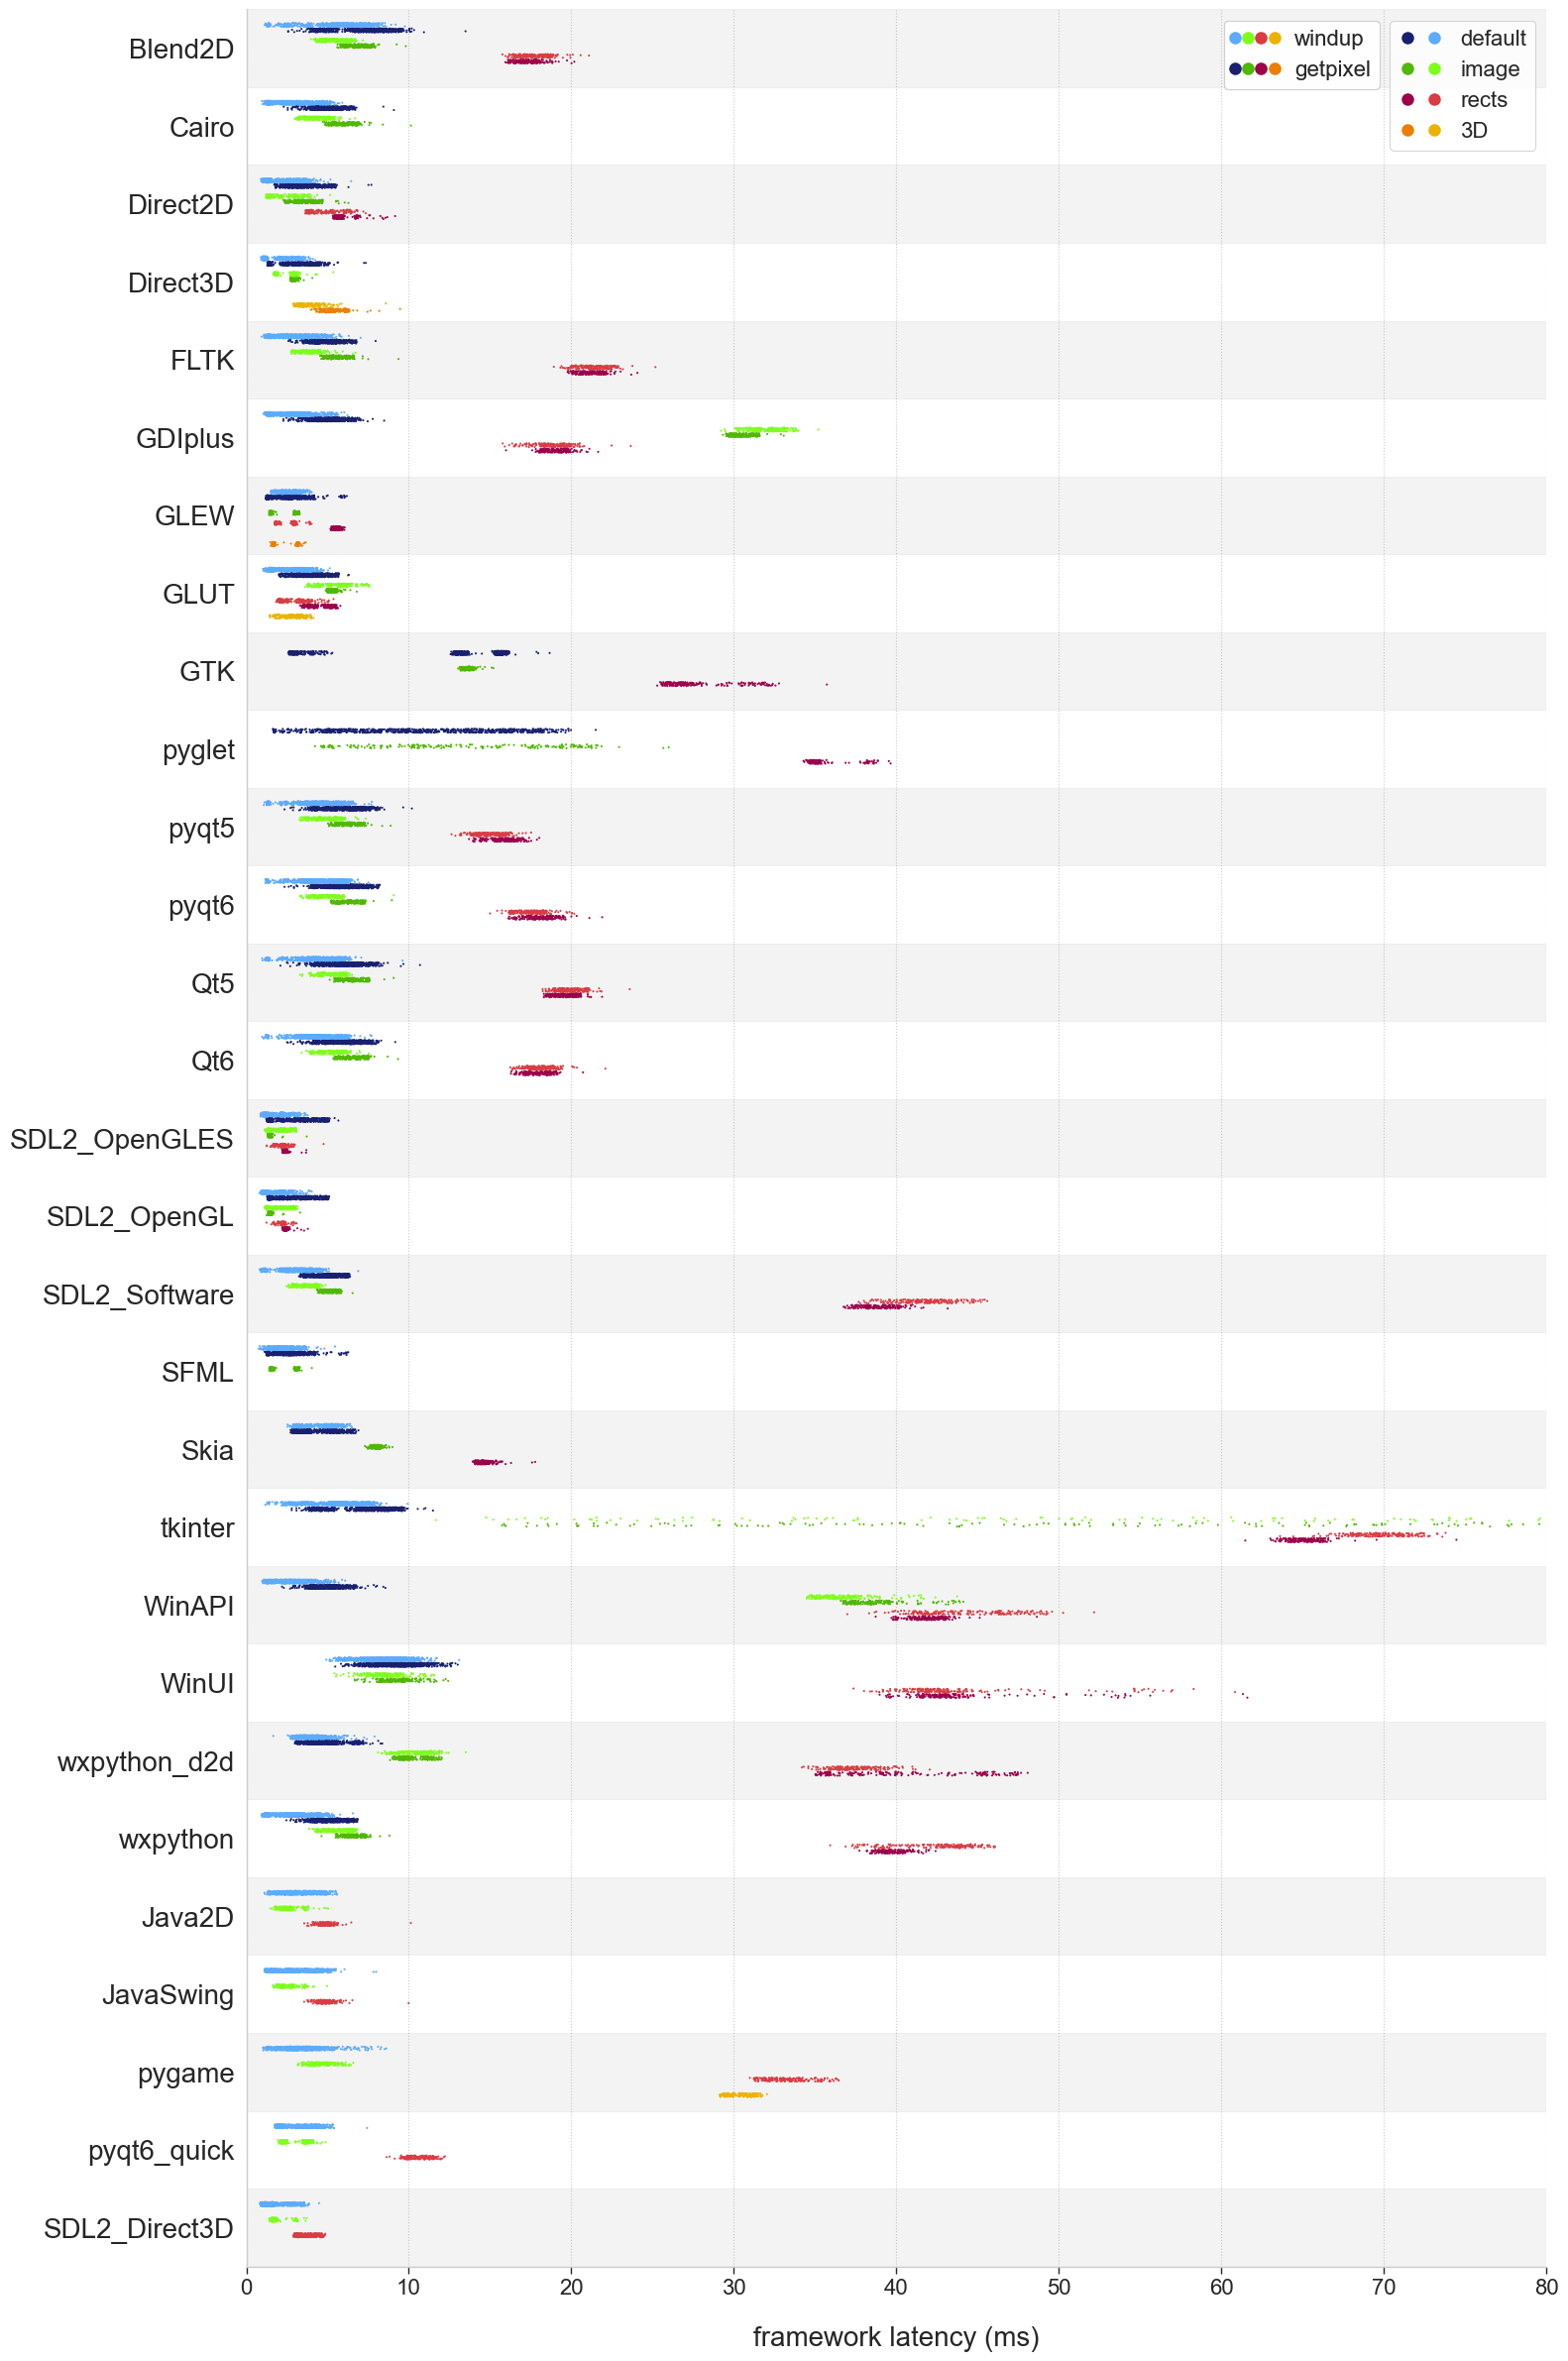

In [67]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(16, 24), "xtick.bottom": True, "grid.linestyle": ":"})

offset = lambda p: transforms.ScaledTranslation(0, p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

sns.stripplot(data=data[data['program'] == 'windup'], y='framework', x='fw', hue='complexity', hue_order=['default', 'image', 'rects', '3D'], dodge=True, palette=PALETTE_DARK, size=1.5, transform=offset(0.05)+trans)
plot = sns.stripplot(data=data[data['program'] == 'getpixel'], y='framework', x='fw', hue='complexity', hue_order=['default', 'image', 'rects', '3D'], dodge=True, palette=PALETTE_LIGHT, size=1.5)

# stripped background
for i in range(len(data['framework'].unique())):
    if i % 2 == 0:
        plot.axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
plot.set_ylim(-0.5, len(data['framework'].unique()) - 0.5)

# increase label size
plot.set_xlabel('framework latency (ms)', fontsize=20)
plot.xaxis.labelpad = 20
plot.set_ylabel('')

plot.set_xlim(left=0, right=80)  # note that cairo rects, pyglet 3d, and some tkinter image are cut off
plot.tick_params(axis='y', labelsize=20)
plot.tick_params(axis='x', labelsize=16)
plt.legend(title='', fontsize=20, loc='upper right')

handles, labels = plot.get_legend_handles_labels()
print(handles)
print(labels)

handles_getpixel = (handles[0], handles[1], handles[2], handles[3])
handles_windup = (handles[4], handles[5], handles[6], handles[7])

handles_default = (handles[0], handles[4])
handles_image = (handles[1], handles[5])
handles_rects = (handles[2], handles[6])
handles_3d = (handles[3], handles[7])

condition_legend = plot.legend([handles_default, handles_image, handles_rects, handles_3d], ['default', 'image', 'rects', '3D'], markerscale=6., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=16)
program_legend = plot.legend([handles_windup, handles_getpixel], ['windup', 'getpixel'], markerscale=6., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(0.88, 1), fontsize=16)
plt.gca().add_artist(condition_legend)
plt.gca().add_artist(program_legend)

plt.gca().invert_yaxis()
sns.despine(bottom = False, left = False)
plt.tight_layout()
plt.savefig("frameworks_results.pdf", format='pdf')

In [63]:
# sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(10, 5), "xtick.bottom": True, "grid.linestyle": ":"})

# plot = sns.stripplot(data=data[data['framework']=='UnrealEngine5'], x='program', y='diff', hue='complexity', size=2, dodge=True, palette=[COLOR_BLUE, COLOR_GLUTROT, 'orange', 'green'])
# # plot = sns.boxplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], dodge=True, palette=['red', 'orange', 'darkred', 'blue'])
# # plot.axes.set_ylim(-25, 50)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)